In [2]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [51]:
import dill
dill.dump_session('./data_bruckner/data/notebookData/6_width_vs_CorrLength_vs_SystemSize')

In [ ]:
import dill
dill.load_session('./data_bruckner/data/notebookData/6_width_vs_CorrLength_vs_SystemSize')

In [2]:
def beta_from_corrLength(corrLen):
    beta = np.tan((np.exp(-1./corrLen)))
    return beta

In [3]:
#corrLengths = np.array([0.1,0.5,1.,5,10.,20.,50,100])
corrLengths = np.linspace(2.5,10,20)
#corrLengths = np.array([1,1.5,2,2.5,3])
beta = beta_from_corrLength(corrLengths)
print beta
print corrLengths

[ 0.79277524  0.8558812   0.90917458  0.95481915  0.99437613  1.02900294
  1.05957744  1.08677851  1.11113994  1.13308762  1.15296567  1.17105535
  1.18758886  1.20275966  1.21673027  1.22963822  1.24160075  1.25271839
  1.26307784  1.27275433]
[  2.5          2.89473684   3.28947368   3.68421053   4.07894737
   4.47368421   4.86842105   5.26315789   5.65789474   6.05263158
   6.44736842   6.84210526   7.23684211   7.63157895   8.02631579
   8.42105263   8.81578947   9.21052632   9.60526316  10.        ]


In [4]:
#Defining Parameters
Num_configs = 10000
Nstep       = beta*1000/1.5 #The number of Markov Chain steps for no correlation in the input data. This number was dec
                            # by checking the numebr of steps required for highest beta value which is 1000, which we scale further down.
#N           = corrLengths*30 #The 30 factor was obtained by previous simulations where the system performed well with this sytems size

N = np.linspace(30,315,20)

print N

#for i in np.arange(len(N)):
   # N[i] = np.int(max(30,np.int(N[i]))) # We fix the minimum number of spins to 30

#Change the array type to int array from float array
N = N.astype(int)
Nstep = Nstep.astype(int)

[  30.   45.   60.   75.   90.  105.  120.  135.  150.  165.  180.  195.
  210.  225.  240.  255.  270.  285.  300.  315.]


In [ ]:
%%capture captX

Xdata_big    = []
Xresults_big = []

Xdata_mid    = []
Xresults_mid = []

XBM      = []
Xdata    = []
Xresults = []
XRBM     = []

Num_reps = 1

for k in range(Num_reps):
    
    Xdata_big.append(Xdata_mid)
    Xresults_big.append(Xresults_mid)
    
    Xdata_mid = []
    Xresults_mid = []
    
    for j in np.arange(len(N)):
        
        Xdata_mid.append(Xdata)
        Xresults_mid.append(Xresults)

        XBM      = []
        Xdata    = []
        Xresults = []
        XRBM     = []
        
        for i in np.arange(len(beta)):
            #Generate spins using Gibbs Sampling MCMC
            XBM.append(bm.BM(N=N[j],nature='Spin'))

            #Define Couplings
            XBM[i].layer.couplings =  beta[i]*(np.eye(N=N[j],k=1) + np.eye(N=N[j],k=-1) )
            XBM[i].layer.couplings[0,-1] += beta[i]
            XBM[i].layer.couplings[-1,0] += beta[i]

            #Generating the ising model data
            Xdata.append(XBM[i].gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=Nstep[i])) # N steps.

            #Train the model
            XRBM.append(rbm.RBM(visible = 'Spin', n_v=N[j], n_h = 1, hidden = 'Spin',zero_field = True))
            Xresults.append(XRBM[i].fit(Xdata[i],n_iter=250,verbose=0,learning_rate = 0.001,record=['W'],record_interval=100,batch_size=10,N_MC= 20, lr_decay=False,batch_norm=False))
            
    #del Xdata_mid[0]
    #del Xresults_mid[0]

#del Xdata_big[0]
#del Xresults_big[0]

In [16]:
#Calculating the average peak Width and the STDV in the width
import peakWidth

corrLen_over_N = []
PW_over_corrLen = []
PW_over_corrLen_error = []

t1 = np.zeros(Num_reps)
PW_avg = np.zeros((len(N),len(beta))) 
PW_std = np.zeros((len(N),len(beta)))

for j in range(len(N)):
    for i in range(len(beta)):
        for k in range(Num_reps):
            t1[k] = peakWidth.peakWidth(Xresults_big[k][j][i],plot=False)
        PW_avg[j,i] = np.mean(t1)
        PW_std[j,i] = np.std(t1)
        corrLen_over_N.append(corrLength[i]/N[j])
        PW_over_corrLen.append(PW_avg[j,i]/corrLength[i])
        PW_over_corrLen_error.append(PW_std[j,i]/corrLength[i])

IndexError: list index out of range

In [ ]:
plt.errorbar(np.exp(-corrLen_over_N),PW_over_corrLen,yerr=PW_over_corrLen_error,fmt='.',ecolor='g')

In [29]:
# Since We only did one run, plot that:

import peakWidth
reload(peakWidth)

corrLen_over_N = []
PW_over_corrLen = []
#PW_over_corrLen_error = []

PW_avg = np.zeros((len(N),len(beta))) 
#PW_std = np.zeros((len(N),len(beta)))

for j in range(len(N)-1):
    for i in range(len(beta)):
        PW_avg[j,i] = np.array(peakWidth.peakWidth(np.array(Xresults_mid[j][i]['W'])[-1,0,:],plot=False))
        corrLen_over_N.append(corrLengths[i]/N[j])
        PW_over_corrLen.append(PW_avg[j,i]/corrLengths[i])

(0.84, 1)

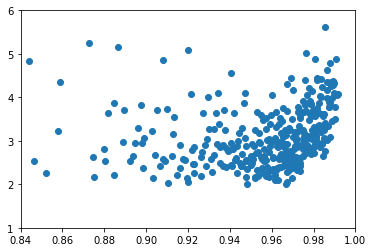

In [39]:
plt.figure
plt.scatter(np.exp(-np.array(corrLen_over_N)),np.array(PW_over_corrLen))
plt.ylim(1,6)
plt.xlim(0.84,1)

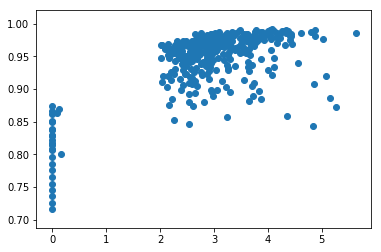

In [50]:
plt.scatter(np.array(PW_over_corrLen),np.exp(-np.array(corrLen_over_N)))

In [ ]:
sum_weights_over_corrLen = []
#sum_weights_over_corrLen_error = []

#t1 = np.zeros(Num_reps)
sum_weights_avg = np.zeros((len(N),len(beta))) 
#sum_weights_std = np.zeros((len(N),len(beta)))

for j in range(len(N)):
    for i in range(len(beta)):
        #for k in range(1,Num_reps):
            #t1[k] = abs(np.sum(np.array(Xresults[j][i]['W'])[-1,0,:]))
        sum_weights_avg[j,i] = np.sum(np.array(Xresults_mid[j][i]['W'])[-1,0,:])
        #sum_weights_std[j,i] = np.std(t1[1:])
        sum_weights_over_corrLen.append(sum_weights_avg[j,i]/corrLengths[i])
        #sum_weights_over_corrLen_error.append(sum_weights_std[j,i]/corrLengths[i])

In [ ]:
plt.scatter(np.array(sum_weights_over_corrLen),np.exp(-np.array(corrLen_over_N)))